In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook()

# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-09-19 
Git hash: 3e6018d790e56d8ccd70647a7eccff8c120a8e6d


In [3]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sramongo']
ncbi = db['ncbi']

In [4]:
from dask.distributed import Client
from dask import delayed

daskClient = Client()

In [5]:
labels = pd.DataFrame(list(ncbi.aggregate([
    {'$unwind': {'path': '$runs'}},
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'library_strategy': '$sra.experiment.library_strategy'
        }
    },
])))

labels.set_index(['srx', 'srr'], inplace=True)
labels = labels.library_strategy

In [6]:
expression = labels[labels.isin(['RNA-Seq', 'EST', 'WGS', 'ChIP-Seq'])]
expression_srx = expression.index.get_level_values('srx').unique()

In [7]:
# collect RNA-seq metrics
cols = [
    'PCT_CODING_BASES',
    'PCT_UTR_BASES',
    'PCT_INTRONIC_BASES',
    'PCT_INTERGENIC_BASES',
    'PCT_MRNA_BASES',
    'MEDIAN_CV_COVERAGE',
    'MEDIAN_5PRIME_BIAS',
    'MEDIAN_3PRIME_BIAS'
]

cm = store.select('prealn/workflow/collectrnaseqmetrics/unstranded', where='srx == expression_srx', columns=cols)

In [8]:
# markduplicates
cols = [
    'PERCENT_DUPLICATION',
]

mark = store.select('prealn/workflow/markduplicates', columns=cols)

In [9]:
# pullin in gene level counts and get proportion of genes on and the log STD of gene counts
@delayed
def read_df(srx, pth):
    df = pd.read_parquet(pth)
    _mean = (df['count'] > 0).mean()
    _std = np.log1p(df['count'].std())
    return srx, _mean, _std

work = []
for srx in expression_srx:
    pth = Path(f'../output/aln-wf/gene_counts/{srx}.parquet') 
    if pth.exists():
        work.append(read_df(srx, pth.as_posix()))

futures = daskClient.compute(work)
res = daskClient.gather(futures)
prop_genes_on = pd.DataFrame(res, columns=['srx', 'prop_genes_on', 'log_std']).set_index('srx')

In [10]:
prop_genes_on = prop_genes_on.join(labels.reset_index().groupby('srx').first().library_strategy).copy()

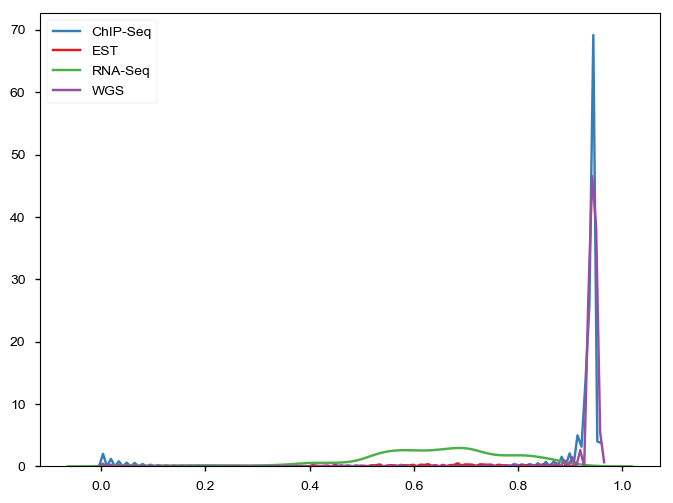

In [11]:
for n, dd in prop_genes_on.groupby('library_strategy'):
    sns.kdeplot(dd.prop_genes_on, label=n)

In [17]:
# pullin in intergenic level counts and get proportion of intergenic regions on and the log STD of gene counts
@delayed
def read_df(srx, pth):
    df = pd.read_parquet(pth)
    _mean = (df['count'] > 0).mean()
    _std = np.log1p(df['count'].std())
    return srx, _mean, _std

work = []
for srx in expression_srx:
    pth = Path(f'../output/aln-wf/intergenic_counts/{srx}.parquet') 
    if pth.exists():
        work.append(read_df(srx, pth.as_posix()))

futures = daskClient.compute(work)
res = daskClient.gather(futures)
prop_intergenic_on = pd.DataFrame(res, columns=['srx', 'prop_intergenic_on', 'log_intergenic_std']).set_index('srx')

In [18]:
prop_intergenic_on = prop_intergenic_on.join(labels.reset_index().groupby('srx').first().library_strategy).copy()

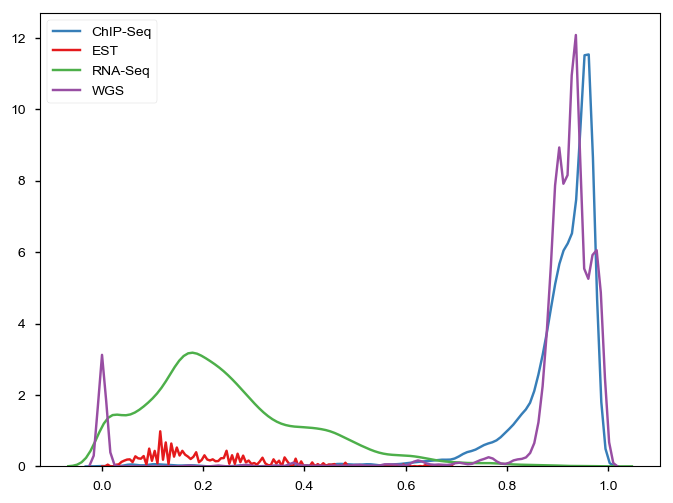

In [19]:
for n, dd in prop_intergenic_on.groupby('library_strategy'):
    sns.kdeplot(dd.prop_intergenic_on, label=n)

In [62]:
# pullin in intergenic level counts and get proportion of intergenic regions on and the log STD of gene counts
@delayed
def read_df(srx, pth):
    junc = pd.read_parquet(pth)
    
    # filter junction that are not on the same chromosome and not in a real gene
    junc = junc[(junc.Site1_chr == junc.Site2_chr) & (np.abs(junc.Site1_location - junc.Site2_location) > 500)].copy()
    junc = junc[~junc.PrimaryGene.isna()].copy()
    
    junc_reads = junc['count'].sum()
    junctions = junc.shape[0]
    return srx, junc_reads, junctions

work = []
for srx in expression_srx:
    pth = Path(f'../output/aln-wf/junction_counts/{srx}.parquet') 
    if pth.exists():
        work.append(read_df(srx, pth.as_posix()))

futures = daskClient.compute(work)
res = daskClient.gather(futures)
junctions = pd.DataFrame(res, columns=['srx', 'num_junction_reads', 'num_of_junctions']).set_index('srx')

In [63]:
junctions = junctions.join(labels.reset_index().groupby('srx').first().library_strategy).copy()

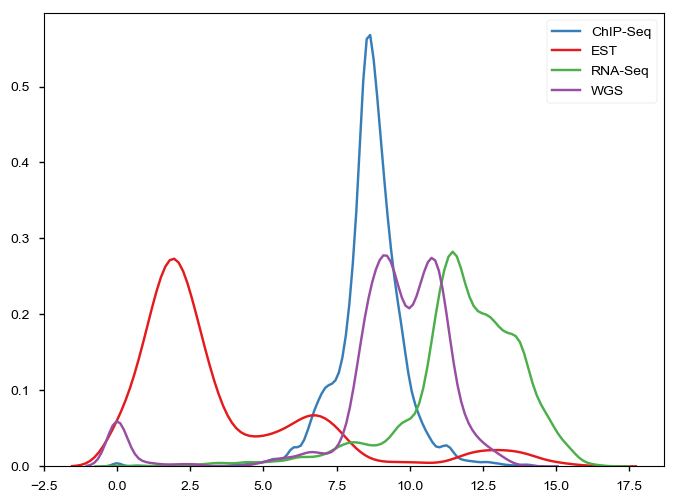

In [64]:
for n, dd in junctions.groupby('library_strategy'):
    _dat = np.log1p(dd.num_junction_reads.astype(np.int64))
    sns.kdeplot(_dat, label=n)

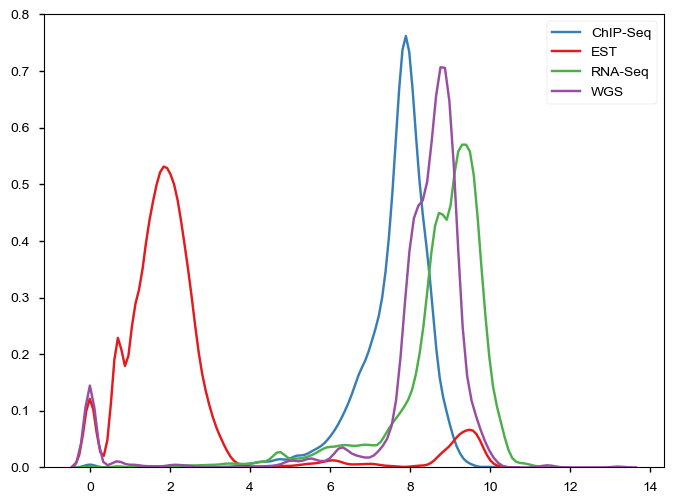

In [65]:
for n, dd in junctions.groupby('library_strategy'):
    _dat = np.log1p(dd.num_of_junctions.astype(np.int64))
    sns.kdeplot(_dat, label=n)

In [48]:
srx = 'SRX4053417'
pth = Path(f'../output/aln-wf/junction_counts/{srx}.parquet') 
pd.read_parquet(pth)

,PrimaryGene,Site1_chr,Site1_location,Site1_strand,Site2_chr,Site2_location,Site2_strand,count,srx
0,None,chrUn_DS484241v1,560,NaN,chrUn_DS484241v1,617,NaN,1,SRX4053417
1,None,chrUn_DS484241v1,560,NaN,chrUn_DS484241v1,678,NaN,1,SRX4053417
2,None,chrUn_DS484241v1,764,NaN,chrUn_DS484241v1,832,NaN,7,SRX4053417
3,FBgn0002121,chr2L,11344,NaN,chr2L,11410,NaN,13,SRX4053417
4,FBgn0002121,chr2L,11518,NaN,chr2L,11779,NaN,9,SRX4053417
5,FBgn0002121,chr2L,12221,NaN,chr2L,12286,NaN,11,SRX4053417
6,FBgn0002121,chr2L,12928,NaN,chr2L,13520,NaN,7,SRX4053417
7,FBgn0002121,chr2L,13625,NaN,chr2L,13683,NaN,10,SRX4053417
8,FBgn0002121,chr2L,14874,NaN,chr2L,14933,NaN,11,SRX4053417
9,FBgn0002121,chr2L,15711,NaN,chr2L,17053,NaN,1,SRX4053417


In [51]:
junctions.num_junction_reads.describe()

count     23944
unique    20802
top           0
freq         92
Name: num_junction_reads, dtype: int64

In [53]:
junctions.num_of_junctions.describe()

count     23944.000000
mean      23193.909455
std       21256.696310
min           0.000000
25%        3399.250000
50%       20778.500000
75%       37344.000000
max      612432.000000
Name: num_of_junctions, dtype: float64

In [61]:
junctions.num_of_junctions.describe()

count     23944.000000
mean      11419.370489
std       11902.104199
min           0.000000
25%        1638.000000
50%        9155.500000
75%       17735.500000
max      570668.000000
Name: num_of_junctions, dtype: float64

## Build X

In [5]:
X = store['prealn/workflow/collectrnaseqmetrics/first'].dropna(axis=1)

## Build Y

In [69]:
Y = pd.DataFrame(list(ncbi.aggregate([
    {'$unwind': {'path': '$runs'}},
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'library_strategy': '$sra.experiment.library_strategy'
        }
    },
])))

Y.set_index(['srx', 'srr'], inplace=True)

In [70]:
Y = Y.reindex(X.index)

In [71]:
Y = Y.library_strategy.values

## Model

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [82]:
lbl_maker = LabelEncoder()
Y_label = lbl_maker.fit_transform(Y.tolist())

In [83]:
# Split the data into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_label)

In [84]:
# scale data
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

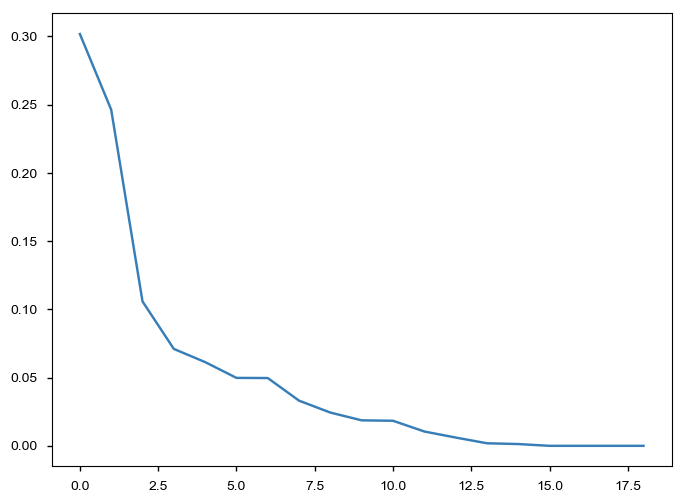

In [86]:
pca = PCA()
pca.fit(X_train_scale)
plt.plot(pca.explained_variance_ratio_)

In [87]:
pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.fit_transform(X_test_scale)

In [110]:
forest = RandomForestClassifier(n_estimators=100, max_features=3)
forest.fit(X_train_pca, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [111]:
Y_forest = forest.predict(X_test_pca)
prob_pos = forest.predict_proba(X_test_pca)

In [112]:
print(classification_report(Y_test, Y_forest, target_names=lbl_maker.classes_))

                        precision    recall  f1-score   support

              AMPLICON       0.00      0.00      0.00        21
         Bisulfite-Seq       0.00      0.00      0.00         2
                 CLONE       0.00      0.00      0.00         2
              CLONEEND       0.62      0.87      0.72       865
              ChIP-Seq       0.00      0.00      0.00         1
DNase-Hypersensitivity       0.49      0.88      0.63      1174
                   EST       0.00      0.00      0.00         6
             FAIRE-seq       0.00      0.00      0.00         4
               FL-cDNA       0.00      0.00      0.00        30
             MNase-Seq       0.00      0.00      0.00         4
             MeDIP-Seq       0.49      0.43      0.46      1154
                 OTHER       0.00      0.00      0.00         4
             POOLCLONE       0.50      0.25      0.33        16
               RIP-Seq       0.88      0.77      0.82      4651
               RNA-Seq       0.00      

/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 19, does not match size of target_names, 21
  .format(len(labels), len(target_names))
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
